---
## 1. Environment Setup

This section detects the environment (Kaggle or local).

In [1]:
# Check if running on Kaggle
import os
try:
    if os.path.exists('/kaggle/input'):
        ON_KAGGLE = True
        print("✓ Running on Kaggle")
    else:
        ON_KAGGLE = False
        print("✓ Running on local environment")
except:
    ON_KAGGLE = False
    print("✓ Running on local environment")

✓ Running on Kaggle


In [2]:
# Kaggle dataset paths (if on Kaggle)
if ON_KAGGLE:
    print("✓ Kaggle environment detected")
    print("Datasets available at: /kaggle/input/")
    print("Working directory: /kaggle/working/")
else:
    print("Using local environment")

✓ Kaggle environment detected
Datasets available at: /kaggle/input/
Working directory: /kaggle/working/


---
## 2. Import Required Libraries

In [3]:
# Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import shutil
import warnings
warnings.filterwarnings('ignore')

# Set display parameters
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['figure.dpi'] = 100
%matplotlib inline

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


---
## 3. Load Dataset Paths

In [4]:
# ============================================================================
# DATASET PATH CONFIGURATION
# ============================================================================

import zipfile

# Auto-detect Kaggle dataset or use local path
if ON_KAGGLE:
    kaggle_input = Path('/kaggle/input')
    BASE_DATA_DIR = None
    
    print("🔍 Searching for dataset in /kaggle/input/...")
    potential_datasets = [d for d in kaggle_input.iterdir() if d.is_dir()]
    print(f"   Found {len(potential_datasets)} dataset(s)")
    
    # Try to find dataset with train/val/test structure
    for dataset_dir in potential_datasets:
        print(f"   Checking: {dataset_dir.name}")
        
        # Check direct structure
        if (dataset_dir / 'train' / 'images').exists():
            BASE_DATA_DIR = dataset_dir
            print(f"   ✓ Found train/images in {dataset_dir.name}")
            break
        
        # Check nested structure (one level deep)
        subdirs = [d for d in dataset_dir.iterdir() if d.is_dir()]
        for subdir in subdirs:
            if (subdir / 'train' / 'images').exists():
                BASE_DATA_DIR = subdir
                print(f"   ✓ Found train/images in {dataset_dir.name}/{subdir.name}")
                break
        
        if BASE_DATA_DIR:
            break
    
    # If still not found, use first dataset
    if BASE_DATA_DIR is None:
        print(f"\n⚠ Could not auto-detect standard dataset structure")
        if potential_datasets:
            BASE_DATA_DIR = potential_datasets[0]
            print(f"\n   Using: {BASE_DATA_DIR.name}")
        else:
            print(f"\n❌ No datasets found in /kaggle/input/")
            BASE_DATA_DIR = kaggle_input
else:
    BASE_DATA_DIR = Path('dataset')

print(f"\n🎯 Using BASE_DATA_DIR: {BASE_DATA_DIR}")

# Define input paths
TRAIN_IMAGES = BASE_DATA_DIR / 'train' / 'images'
TRAIN_MASKS = BASE_DATA_DIR / 'train' / 'masks'
VAL_IMAGES = BASE_DATA_DIR / 'val' / 'images'
VAL_MASKS = BASE_DATA_DIR / 'val' / 'masks'
TEST_IMAGES = BASE_DATA_DIR / 'test' / 'images'
TEST_MASKS = BASE_DATA_DIR / 'test' / 'masks'

# Define output directory for processed data
# On Kaggle, save to /kaggle/working/ (writable directory)
if ON_KAGGLE:
    PROCESSED_DIR = Path('/kaggle/working/processed_dataset')
else:
    PROCESSED_DIR = Path('processed_dataset')

# Create output directory structure
PROCESSED_TRAIN_IMAGES = PROCESSED_DIR / 'train' / 'images'
PROCESSED_TRAIN_MASKS = PROCESSED_DIR / 'train' / 'masks'
PROCESSED_VAL_IMAGES = PROCESSED_DIR / 'val' / 'images'
PROCESSED_VAL_MASKS = PROCESSED_DIR / 'val' / 'masks'
PROCESSED_TEST_IMAGES = PROCESSED_DIR / 'test' / 'images'
PROCESSED_TEST_MASKS = PROCESSED_DIR / 'test' / 'masks'

print(f"\n📁 Processed data will be saved to: {PROCESSED_DIR}")
print("\nNote: On Kaggle, processed data is saved to /kaggle/working/ which persists during the notebook session.")

# Show what was found
if not TRAIN_IMAGES.exists():
    print(f"\n⚠ Warning: train/images not found at expected location")
    print(f"   Looking in: {TRAIN_IMAGES}")
    if BASE_DATA_DIR.exists():
        print(f"\n   Contents of {BASE_DATA_DIR.name}:")
        for item in sorted(list(BASE_DATA_DIR.iterdir())[:10]):
            if item.is_dir():
                print(f"      📁 {item.name}/")
            else:
                print(f"      📄 {item.name}")

🔍 Searching for dataset in /kaggle/input/...
   Found 1 dataset(s)
   Checking: oilspill
   ✓ Found train/images in oilspill/oil_spill_dataset

🎯 Using BASE_DATA_DIR: /kaggle/input/oilspill/oil_spill_dataset

📁 Processed data will be saved to: /kaggle/working/processed_dataset

Note: On Kaggle, processed data is saved to /kaggle/working/ which persists during the notebook session.


---
## 4. Define Preprocessing Parameters

In [5]:
# Preprocessing configuration
TARGET_SIZE = (256, 256)  # Resize all images to this size
APPLY_DENOISING = True     # Apply median filter for speckle noise
MEDIAN_KERNEL_SIZE = 3     # Kernel size for median filtering

# Data augmentation parameters (for training set only)
APPLY_AUGMENTATION = True
AUGMENTATION_FACTOR = 2    # How many augmented versions per image (1 = no augmentation, 2 = double dataset)

print("="*70)
print("PREPROCESSING CONFIGURATION")
print("="*70)
print(f"Target size: {TARGET_SIZE}")
print(f"Apply denoising: {APPLY_DENOISING}")
if APPLY_DENOISING:
    print(f"Median kernel size: {MEDIAN_KERNEL_SIZE}")
print(f"Apply augmentation: {APPLY_AUGMENTATION}")
if APPLY_AUGMENTATION:
    print(f"Augmentation factor: {AUGMENTATION_FACTOR}x")
print("="*70)

PREPROCESSING CONFIGURATION
Target size: (256, 256)
Apply denoising: True
Median kernel size: 3
Apply augmentation: True
Augmentation factor: 2x


---
## 5. Create Output Directories

In [6]:
# Create all necessary directories
directories = [
    PROCESSED_TRAIN_IMAGES,
    PROCESSED_TRAIN_MASKS,
    PROCESSED_VAL_IMAGES,
    PROCESSED_VAL_MASKS,
    PROCESSED_TEST_IMAGES,
    PROCESSED_TEST_MASKS
]

for directory in directories:
    directory.mkdir(parents=True, exist_ok=True)

print("✓ Created output directory structure:")
print(f"  {PROCESSED_DIR}/")
print(f"  ├── train/")
print(f"  │   ├── images/")
print(f"  │   └── masks/")
print(f"  ├── val/")
print(f"  │   ├── images/")
print(f"  │   └── masks/")
print(f"  └── test/")
print(f"      ├── images/")
print(f"      └── masks/")

✓ Created output directory structure:
  /kaggle/working/processed_dataset/
  ├── train/
  │   ├── images/
  │   └── masks/
  ├── val/
  │   ├── images/
  │   └── masks/
  └── test/
      ├── images/
      └── masks/


---
## 6. Define Preprocessing Functions

In [7]:
def preprocess_image(image_path, target_size=TARGET_SIZE, denoise=True, kernel_size=3):
    """
    Preprocess a single SAR image.
    
    Args:
        image_path: Path to input image
        target_size: Tuple of (width, height) for resizing
        denoise: Whether to apply median filtering
        kernel_size: Kernel size for median filter (odd number)
    
    Returns:
        Preprocessed image as numpy array (normalized to [0, 1])
    """
    # Read image
    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"Could not read image: {image_path}")
    
    # Convert to RGB (OpenCV reads as BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
    
    # Apply median filter to reduce speckle noise
    if denoise:
        img = cv2.medianBlur(img, kernel_size)
    
    # Normalize to [0, 1]
    img = img.astype(np.float32) / 255.0
    
    return img


def preprocess_mask(mask_path, target_size=TARGET_SIZE):
    """
    Preprocess a single mask.
    
    Args:
        mask_path: Path to input mask
        target_size: Tuple of (width, height) for resizing
    
    Returns:
        Preprocessed mask as binary numpy array (0 or 1)
    """
    # Read mask as grayscale
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Could not read mask: {mask_path}")
    
    # Resize with nearest neighbor to preserve binary values
    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    
    # Binarize (threshold at 127) and normalize to {0, 1}
    mask = (mask > 127).astype(np.float32)
    
    return mask


def augment_image_and_mask(image, mask):
    """
    Apply random augmentations to image and mask pair.
    
    Augmentations applied:
    - Horizontal flip (50% chance)
    - Vertical flip (50% chance)
    - Rotation (90, 180, 270 degrees - random choice)
    
    Args:
        image: Input image (H, W, C)
        mask: Input mask (H, W)
    
    Returns:
        Augmented image and mask
    """
    # Horizontal flip
    if np.random.rand() > 0.5:
        image = np.fliplr(image)
        mask = np.fliplr(mask)
    
    # Vertical flip
    if np.random.rand() > 0.5:
        image = np.flipud(image)
        mask = np.flipud(mask)
    
    # Random rotation (0, 90, 180, 270 degrees)
    k = np.random.randint(0, 4)  # Number of 90-degree rotations
    if k > 0:
        image = np.rot90(image, k)
        mask = np.rot90(mask, k)
    
    return image, mask


print("✓ Preprocessing functions defined:")
print("  - preprocess_image(): Resize, denoise, normalize")
print("  - preprocess_mask(): Resize, binarize")
print("  - augment_image_and_mask(): Flip, rotate")

✓ Preprocessing functions defined:
  - preprocess_image(): Resize, denoise, normalize
  - preprocess_mask(): Resize, binarize
  - augment_image_and_mask(): Flip, rotate


---
## 7. Visualize Preprocessing Effect

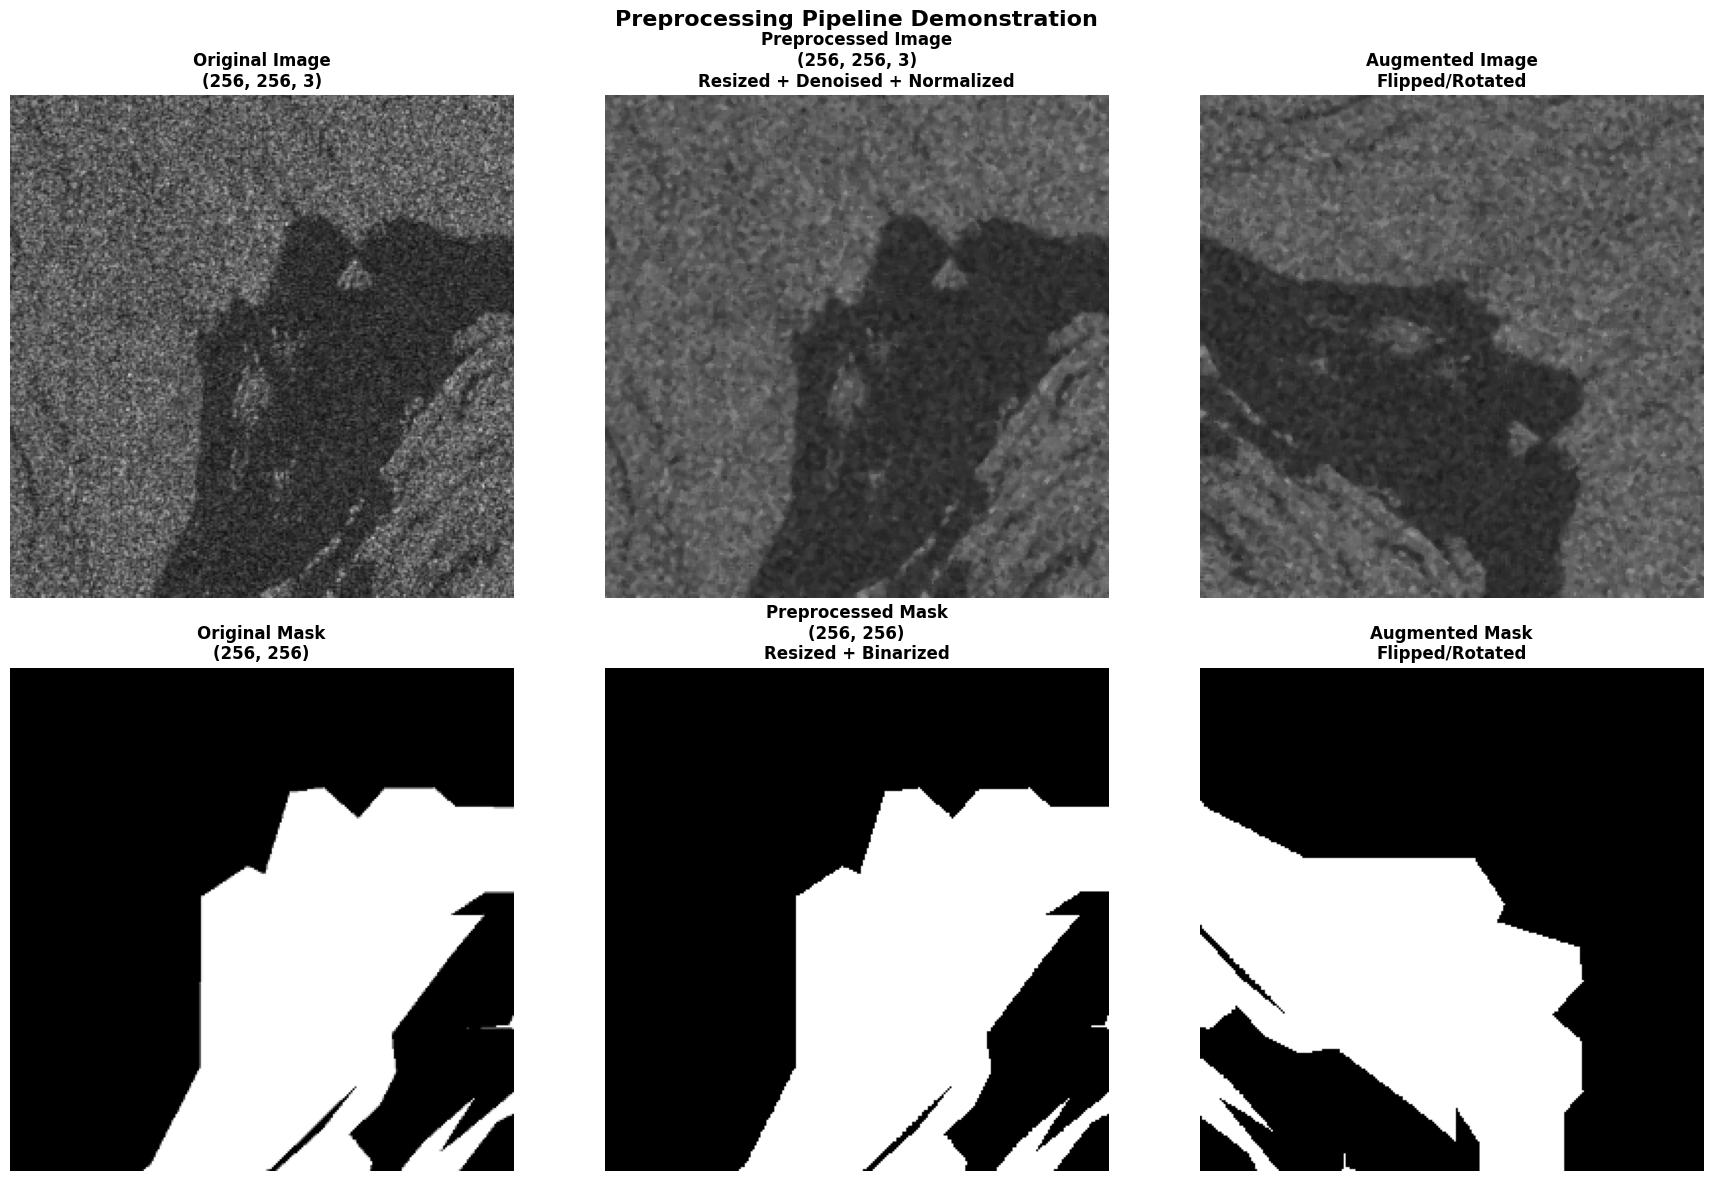


📊 Preprocessing Effects:
  Original size: (256, 256, 3) → Target size: (256, 256, 3)
  Original range: [0, 255] → Normalized range: [0.0, 1.0]
  Speckle noise: Reduced with median filter (kernel=3)
  Augmentation: Random flips and rotations applied


In [8]:
# Load a sample image and mask to demonstrate preprocessing
if not TRAIN_IMAGES.exists():
    print("⚠ Dataset not found in local environment")
    print(f"  Expected path: {TRAIN_IMAGES}")
    print("\n💡 This notebook is designed to run in Google Colab where the dataset is mounted.")
    print("   Please run this notebook in Google Colab to process the actual dataset.")
    print("\n✓ All preprocessing functions are defined and ready to use.")
elif not TRAIN_MASKS.exists():
    print("⚠ Masks directory not found")
    print(f"  Expected path: {TRAIN_MASKS}")
else:
    image_files = list(TRAIN_IMAGES.glob('*.jpg')) + list(TRAIN_IMAGES.glob('*.jpeg')) + list(TRAIN_IMAGES.glob('*.png'))
    
    if len(image_files) > 0:
        # Select first image
        sample_img_path = image_files[0]
        
        # Try to find corresponding mask
        mask_extensions = ['.png', '.jpg', '.jpeg']
        sample_mask_path = None
        for ext in mask_extensions:
            potential_mask = TRAIN_MASKS / f"{sample_img_path.stem}{ext}"
            if potential_mask.exists():
                sample_mask_path = potential_mask
                break
        
        if sample_mask_path is None or not sample_mask_path.exists():
            print(f"⚠ Mask not found for {sample_img_path.name}")
        else:
            # Load original
            orig_img = cv2.imread(str(sample_img_path))
            orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
            orig_mask = cv2.imread(str(sample_mask_path), cv2.IMREAD_GRAYSCALE)
            
            # Preprocess
            proc_img = preprocess_image(sample_img_path, denoise=APPLY_DENOISING)
            proc_mask = preprocess_mask(sample_mask_path)
            
            # Augment (example)
            aug_img, aug_mask = augment_image_and_mask(proc_img.copy(), proc_mask.copy())
            
            # Visualize
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            
            # Original
            axes[0, 0].imshow(orig_img)
            axes[0, 0].set_title(f'Original Image\n{orig_img.shape}', fontweight='bold')
            axes[0, 0].axis('off')
            
            axes[1, 0].imshow(orig_mask, cmap='gray')
            axes[1, 0].set_title(f'Original Mask\n{orig_mask.shape}', fontweight='bold')
            axes[1, 0].axis('off')
            
            # Preprocessed
            axes[0, 1].imshow(proc_img)
            axes[0, 1].set_title(f'Preprocessed Image\n{proc_img.shape}\nResized + Denoised + Normalized', fontweight='bold')
            axes[0, 1].axis('off')
            
            axes[1, 1].imshow(proc_mask, cmap='gray')
            axes[1, 1].set_title(f'Preprocessed Mask\n{proc_mask.shape}\nResized + Binarized', fontweight='bold')
            axes[1, 1].axis('off')
            
            # Augmented
            axes[0, 2].imshow(aug_img)
            axes[0, 2].set_title(f'Augmented Image\nFlipped/Rotated', fontweight='bold')
            axes[0, 2].axis('off')
            
            axes[1, 2].imshow(aug_mask, cmap='gray')
            axes[1, 2].set_title(f'Augmented Mask\nFlipped/Rotated', fontweight='bold')
            axes[1, 2].axis('off')
            
            plt.suptitle('Preprocessing Pipeline Demonstration', fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            print("\n📊 Preprocessing Effects:")
            print(f"  Original size: {orig_img.shape} → Target size: {proc_img.shape}")
            print(f"  Original range: [0, 255] → Normalized range: [0.0, 1.0]")
            print(f"  Speckle noise: Reduced with median filter (kernel={MEDIAN_KERNEL_SIZE})")
            print(f"  Augmentation: Random flips and rotations applied")
    else:
        print("⚠ No images found for demonstration")
        print(f"  Searched in: {TRAIN_IMAGES}")

---
## 8. Process Training Set (with Augmentation)

In [9]:
# Process training set
if TRAIN_IMAGES.exists() and TRAIN_MASKS.exists():
    image_files = sorted(list(TRAIN_IMAGES.glob('*.jpg')) + list(TRAIN_IMAGES.glob('*.jpeg')) + list(TRAIN_IMAGES.glob('*.png')))
    
    print("="*70)
    print("PROCESSING TRAINING SET")
    print("="*70)
    print(f"Total images: {len(image_files)}")
    
    if APPLY_AUGMENTATION:
        print(f"With augmentation (×{AUGMENTATION_FACTOR}): {len(image_files) * AUGMENTATION_FACTOR} images")
    
    processed_count = 0
    augmented_count = 0
    
    for img_path in tqdm(image_files, desc="Processing training images"):
        mask_path = TRAIN_MASKS / f"{img_path.stem}.png"
        
        if not mask_path.exists():
            print(f"\n⚠ Warning: Mask not found for {img_path.name}, skipping...")
            continue
        
        try:
            # Preprocess original
            img = preprocess_image(img_path, denoise=APPLY_DENOISING)
            mask = preprocess_mask(mask_path)
            
            # Save original preprocessed version
            output_img_path = PROCESSED_TRAIN_IMAGES / f"{img_path.stem}.npy"
            output_mask_path = PROCESSED_TRAIN_MASKS / f"{img_path.stem}.npy"
            
            np.save(output_img_path, img)
            np.save(output_mask_path, mask)
            processed_count += 1
            
            # Apply augmentation
            if APPLY_AUGMENTATION:
                for aug_idx in range(AUGMENTATION_FACTOR - 1):  # -1 because we already saved original
                    aug_img, aug_mask = augment_image_and_mask(img.copy(), mask.copy())
                    
                    aug_img_path = PROCESSED_TRAIN_IMAGES / f"{img_path.stem}_aug{aug_idx+1}.npy"
                    aug_mask_path = PROCESSED_TRAIN_MASKS / f"{img_path.stem}_aug{aug_idx+1}.npy"
                    
                    np.save(aug_img_path, aug_img)
                    np.save(aug_mask_path, aug_mask)
                    augmented_count += 1
        
        except Exception as e:
            print(f"\n✗ Error processing {img_path.name}: {e}")
    
    print(f"\n✓ Training set processed successfully!")
    print(f"  Original images processed: {processed_count}")
    print(f"  Augmented images created: {augmented_count}")
    print(f"  Total training samples: {processed_count + augmented_count}")
else:
    print("⚠ Training set not found")

PROCESSING TRAINING SET
Total images: 3848
With augmentation (×2): 7696 images


Processing training images: 100%|██████████| 3848/3848 [02:23<00:00, 26.84it/s]


✓ Training set processed successfully!
  Original images processed: 3848
  Augmented images created: 3848
  Total training samples: 7696


---
## 9. Process Validation Set (No Augmentation)

In [10]:
# Process validation set (no augmentation)
if VAL_IMAGES.exists() and VAL_MASKS.exists():
    image_files = sorted(list(VAL_IMAGES.glob('*.jpg')) + list(VAL_IMAGES.glob('*.jpeg')) + list(VAL_IMAGES.glob('*.png')))
    
    print("="*70)
    print("PROCESSING VALIDATION SET")
    print("="*70)
    print(f"Total images: {len(image_files)}")
    print("Note: No augmentation applied to validation set")
    
    processed_count = 0
    
    for img_path in tqdm(image_files, desc="Processing validation images"):
        mask_path = VAL_MASKS / f"{img_path.stem}.png"
        
        if not mask_path.exists():
            print(f"\n⚠ Warning: Mask not found for {img_path.name}, skipping...")
            continue
        
        try:
            # Preprocess
            img = preprocess_image(img_path, denoise=APPLY_DENOISING)
            mask = preprocess_mask(mask_path)
            
            # Save
            output_img_path = PROCESSED_VAL_IMAGES / f"{img_path.stem}.npy"
            output_mask_path = PROCESSED_VAL_MASKS / f"{img_path.stem}.npy"
            
            np.save(output_img_path, img)
            np.save(output_mask_path, mask)
            processed_count += 1
        
        except Exception as e:
            print(f"\n✗ Error processing {img_path.name}: {e}")
    
    print(f"\n✓ Validation set processed successfully!")
    print(f"  Total samples: {processed_count}")
else:
    print("⚠ Validation set not found")

PROCESSING VALIDATION SET
Total images: 1615
Note: No augmentation applied to validation set


Processing validation images: 100%|██████████| 1615/1615 [00:48<00:00, 33.24it/s]


✓ Validation set processed successfully!
  Total samples: 1615


---
## 10. Process Test Set (No Augmentation)

In [11]:
# Process test set (no augmentation)
if TEST_IMAGES.exists() and TEST_MASKS.exists():
    image_files = sorted(list(TEST_IMAGES.glob('*.jpg')) + list(TEST_IMAGES.glob('*.jpeg')) + list(TEST_IMAGES.glob('*.png')))
    
    print("="*70)
    print("PROCESSING TEST SET")
    print("="*70)
    print(f"Total images: {len(image_files)}")
    print("Note: No augmentation applied to test set")
    
    processed_count = 0
    
    for img_path in tqdm(image_files, desc="Processing test images"):
        mask_path = TEST_MASKS / f"{img_path.stem}.png"
        
        if not mask_path.exists():
            print(f"\n⚠ Warning: Mask not found for {img_path.name}, skipping...")
            continue
        
        try:
            # Preprocess
            img = preprocess_image(img_path, denoise=APPLY_DENOISING)
            mask = preprocess_mask(mask_path)
            
            # Save
            output_img_path = PROCESSED_TEST_IMAGES / f"{img_path.stem}.npy"
            output_mask_path = PROCESSED_TEST_MASKS / f"{img_path.stem}.npy"
            
            np.save(output_img_path, img)
            np.save(output_mask_path, mask)
            processed_count += 1
        
        except Exception as e:
            print(f"\n✗ Error processing {img_path.name}: {e}")
    
    print(f"\n✓ Test set processed successfully!")
    print(f"  Total samples: {processed_count}")
else:
    print("⚠ Test set not found")

PROCESSING TEST SET
Total images: 2606
Note: No augmentation applied to test set


Processing test images: 100%|██████████| 2606/2606 [01:18<00:00, 33.34it/s]


✓ Test set processed successfully!
  Total samples: 2606


---
## 11. Verify Processed Dataset

In [12]:
# Count processed files
train_img_count = len(list(PROCESSED_TRAIN_IMAGES.glob('*.npy')))
train_mask_count = len(list(PROCESSED_TRAIN_MASKS.glob('*.npy')))
val_img_count = len(list(PROCESSED_VAL_IMAGES.glob('*.npy')))
val_mask_count = len(list(PROCESSED_VAL_MASKS.glob('*.npy')))
test_img_count = len(list(PROCESSED_TEST_IMAGES.glob('*.npy')))
test_mask_count = len(list(PROCESSED_TEST_MASKS.glob('*.npy')))

print("="*70)
print("PROCESSED DATASET SUMMARY")
print("="*70)

print(f"\n📊 Training Set:")
print(f"   Images: {train_img_count}")
print(f"   Masks:  {train_mask_count}")
print(f"   Match:  {'✓ Yes' if train_img_count == train_mask_count else '✗ No'}")

print(f"\n📊 Validation Set:")
print(f"   Images: {val_img_count}")
print(f"   Masks:  {val_mask_count}")
print(f"   Match:  {'✓ Yes' if val_img_count == val_mask_count else '✗ No'}")

print(f"\n📊 Test Set:")
print(f"   Images: {test_img_count}")
print(f"   Masks:  {test_mask_count}")
print(f"   Match:  {'✓ Yes' if test_img_count == test_mask_count else '✗ No'}")

total_images = train_img_count + val_img_count + test_img_count
print(f"\n📊 Total Processed:")
print(f"   Total Images: {total_images}")

# Load and verify a sample
if train_img_count > 0:
    sample_img_path = list(PROCESSED_TRAIN_IMAGES.glob('*.npy'))[0]
    sample_mask_path = PROCESSED_TRAIN_MASKS / sample_img_path.name
    
    sample_img = np.load(sample_img_path)
    sample_mask = np.load(sample_mask_path)
    
    print(f"\n📋 Sample Verification:")
    print(f"   Image shape: {sample_img.shape}")
    print(f"   Image dtype: {sample_img.dtype}")
    print(f"   Image range: [{sample_img.min():.3f}, {sample_img.max():.3f}]")
    print(f"   Mask shape: {sample_mask.shape}")
    print(f"   Mask dtype: {sample_mask.dtype}")
    print(f"   Mask unique values: {np.unique(sample_mask)}")

print("\n" + "="*70)
print("✓ PREPROCESSING COMPLETE!")
print("="*70)
print(f"\nProcessed data location: {PROCESSED_DIR}")
print("\nReady for model training (Notebook 4-5)")

PROCESSED DATASET SUMMARY

📊 Training Set:
   Images: 7696
   Masks:  7696
   Match:  ✓ Yes

📊 Validation Set:
   Images: 1615
   Masks:  1615
   Match:  ✓ Yes

📊 Test Set:
   Images: 2606
   Masks:  2606
   Match:  ✓ Yes

📊 Total Processed:
   Total Images: 11917

📋 Sample Verification:
   Image shape: (256, 256, 3)
   Image dtype: float32
   Image range: [0.004, 0.690]
   Mask shape: (256, 256)
   Mask dtype: float32
   Mask unique values: [0. 1.]

✓ PREPROCESSING COMPLETE!

Processed data location: /kaggle/working/processed_dataset

Ready for model training (Notebook 4-5)


---
## 12. Visualize Processed Samples

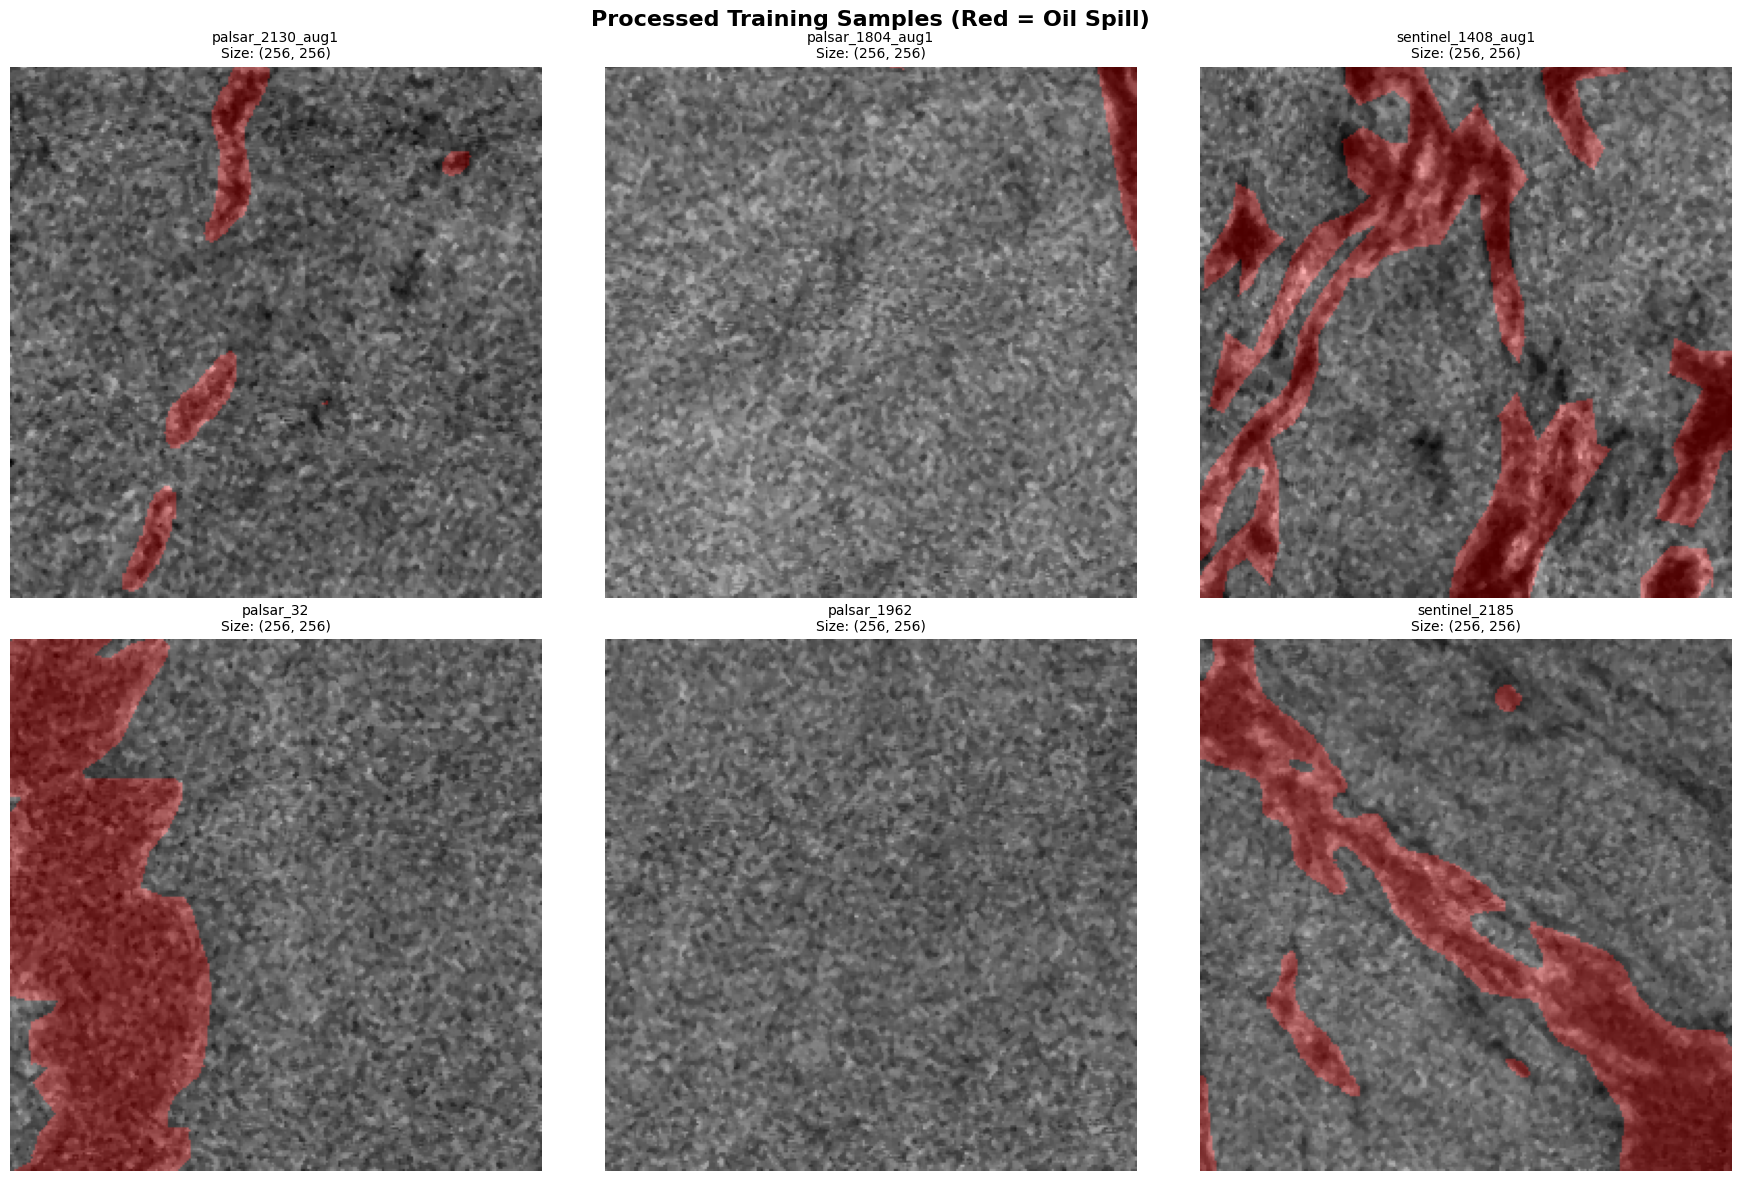


✓ All images are now:
  - Resized to (256, 256)
  - Normalized to [0.0, 1.0]
  - Denoised (speckle noise reduced)
  - Augmented (training set only)


In [13]:
# Visualize random processed samples
if train_img_count >= 6:
    processed_files = list(PROCESSED_TRAIN_IMAGES.glob('*.npy'))
    sample_indices = np.random.choice(len(processed_files), min(6, len(processed_files)), replace=False)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for idx, file_idx in enumerate(sample_indices):
        img_path = processed_files[file_idx]
        mask_path = PROCESSED_TRAIN_MASKS / img_path.name
        
        img = np.load(img_path)
        mask = np.load(mask_path)
        
        # Create overlay
        overlay = img.copy()
        red_overlay = np.zeros_like(img)
        red_overlay[:, :, 0] = mask
        overlay = overlay * 0.7 + red_overlay * 0.3
        
        axes[idx].imshow(overlay)
        axes[idx].set_title(f'{img_path.stem}\nSize: {img.shape[:2]}', fontsize=10)
        axes[idx].axis('off')
    
    plt.suptitle('Processed Training Samples (Red = Oil Spill)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n✓ All images are now:")
    print(f"  - Resized to {TARGET_SIZE}")
    print(f"  - Normalized to [0.0, 1.0]")
    print(f"  - Denoised (speckle noise reduced)")
    print(f"  - Augmented (training set only)")
else:
    print("⚠ Not enough samples to visualize")

---
## 13. Summary and Next Steps

### What We Accomplished:

1. **Resized** all images to 256×256 pixels
2. **Normalized** pixel values from [0, 255] to [0, 1]
3. **Denoised** images using median filtering to reduce SAR speckle noise
4. **Binarized** masks to {0, 1} values
5. **Augmented** training data with flips and rotations
6. **Saved** processed data as `.npy` files for fast loading

### Key Achievements:

- ✅ Consistent input size for neural network
- ✅ Reduced noise improves feature extraction
- ✅ Normalized values stabilize training
- ✅ Augmentation prevents overfitting
- ✅ Ready for model training!

### Next Steps:

- **Notebook 4**: Build Enhanced U-Net model with Attention mechanisms
- **Notebook 5**: Train the model with processed data
- **Notebook 6**: Evaluate and visualize results

---

**End of Notebook 3** ✓

**Next**: Notebook 4 - Model Building